# 0. Load Dependencies

In [18]:
### Import the vulnerability toolkit library
import sys
repoDir = 'C:/Users/Moayad/Documents/GitHub/stickModel'
sys.path.insert(1, f'{repoDir}')
from calibration import stickModelCalibration
from stickModel import stickModel
from utils import *
from units import *

### Import other libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. User Input

In [3]:
### Define Capacity Curves Directory
capCurvesDir= f'{repoDir}/raw/ip-capacities'

### Define Building Class
currentBuildingClass='CR_LFINF+CDM+DUM_H4'

### Define Transformation Factor
gamma=1.33

### Define Storey Height
storeyHeight=2.8

### Define Number of Stories (for single-degree-of-freedom systems, set nst = 1)
nst = 1     # single-degree-of-freedom system

### Define Mass (for single-degree-of-freedom systems in GEM database, set mass = 1.0 tonne)
mass = 1.0  # single-degree-of-freedom system

# 2. Prepare the Model

In [4]:
### Import the equivalent SDOF capacity array 
# This is an array that contains the deformation (1st column) and the strength (2nd column) points. The toolkit requires non-zero
# first entries, therefore if applicable, remove the initial zero rows. Else, the nonlinear material will be ill conditioned and 
# the kernel would exit when running OpenSees
sdofCapArray = np.array(pd.read_csv(f'{capCurvesDir}/{currentBuildingClass}.csv', header = None))[1:,:]

### Construct the height list (for single-degrees-of-freedom, the size of the list is 1x1)
flh = [storeyHeight]*nst

### Construct the mass list (for single-degrees-of-freedom, the size of the list is 1x1)
flm = [mass]*nst

### Extract the storey-strength deformation relationship
rows, columns = np.shape(sdofCapArray)
stD = np.zeros([nst,rows])
stF = np.zeros([nst,rows])
for i in range(nst):
    # get the displacement or spectral displacement arrays at each storey (for sdof, only 1 row)
    stF[i,:] = sdofCapArray[:,1].transpose()
    # get the force or spectral acceleration arrays at each storey (for sdof, only 1 row)
    stD[i,:] = sdofCapArray[:,0].transpose()

# 3. Compile the Model and Run Static Pushover Analysis

WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance


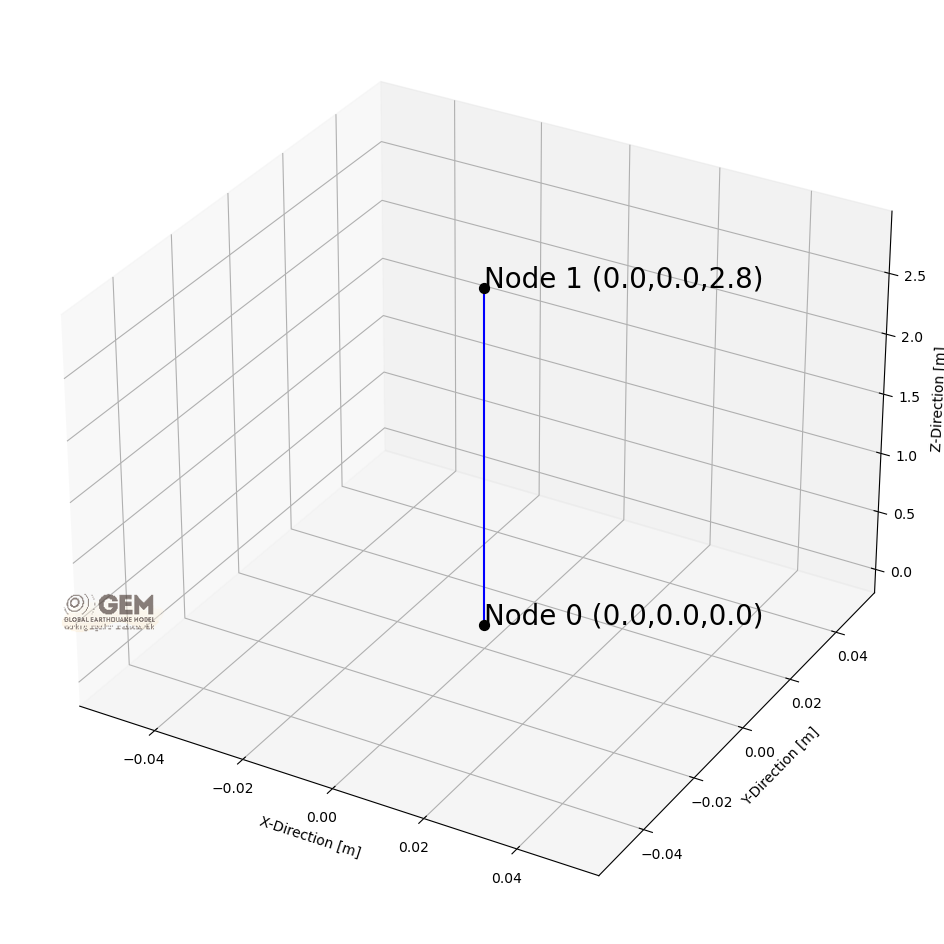

Fundamental Period:  T = 0.851 s

------ Static Pushover Analysis of Node # 1 to 0.1 ---------
Currently pushed node 1 to 0.0005 with 0.02727728883831259
Currently pushed node 1 to 0.001 with 0.05455457767662518
Currently pushed node 1 to 0.0015 with 0.08183186651493778
Currently pushed node 1 to 0.002 with 0.10910915535325036
Currently pushed node 1 to 0.0025 with 0.12580367649188678
Currently pushed node 1 to 0.003 with 0.12970043204021717
Currently pushed node 1 to 0.0035 with 0.13359718758854752
Currently pushed node 1 to 0.004 with 0.1374939431368779
Currently pushed node 1 to 0.0045000000000000005 with 0.1413906986852083
Currently pushed node 1 to 0.005000000000000001 with 0.14528745423353867
Currently pushed node 1 to 0.005500000000000001 with 0.14918420978186903
Currently pushed node 1 to 0.006000000000000002 with 0.1530809653301994
Currently pushed node 1 to 0.006500000000000002 with 0.1569777208785298
Currently pushed node 1 to 0.007000000000000003 with 0.16087447642686015
Cu

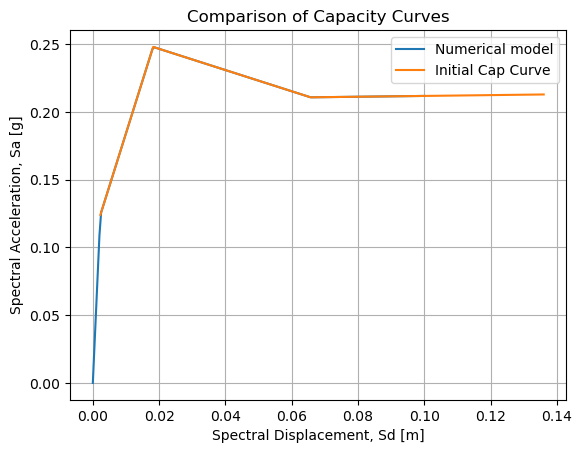

In [20]:
### Initialise the stickModel instance using the parameters defined in previous sections
model = stickModel(nst,flh,flm,stD,stF,currentBuildingClass) # Build the model
model.mdof_initialise()                                      # Initialise the domain
model.mdof_nodes()                                           # Construct the nodes
model.mdof_fixity()                                          # Set the boundary conditions 
model.mdof_loads()                                           # Assign the loads
model.mdof_material()                                        # Assign the nonlinear storey material
model.plot_model()                                           # Visualise the model                               
model.do_gravity_analysis()                                  # Do gravity analysis
T = model.do_modal_analysis(num_modes = 1)                   # Do modal analysis and get period of vibration

# Ignore the warning: "WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance".
# In fact, ZeroLength elements do function for non-zero lengths yet the warning is issued due to this non-conventional use.

### Run static pushover analysis
ref_disp = 0.01               # Define reference displacements, typically corresponds to yield point
disp_scale_factor = 10        # Define displacement scaling factor, typically corresponds to target ductility 
push_dir = 1                  # Define pushover direction (options are: 1 for X, 2 for Y and 3 for Z)
spo_disps, spo_rxn= model.do_spo_analysis(ref_disp,disp_scale_factor,push_dir)

### Plot the comparison
fig=plt.figure()
# Plot the static pushover results
plt.plot(spo_disps[:,-1],spo_rxn,label='Numerical model')
# Plot the initial equivalent SDOF capacity curve definition
plt.plot(sdofCapArray[:,0],sdofCapArray[:,1],label='Initial Cap Curve')
plt.grid(visible=True, which='major')
plt.grid(visible=True, which='minor')
plt.xlabel('Spectral Displacement, Sd [m]')
plt.ylabel('Spectral Acceleration, Sa [g]')
plt.title('Comparison of Capacity Curves')
plt.legend()